## 要点
**Neural Tangents**はGoogle AIが開発した[JAX](https://github.com/google/jax)のラッパーライブラリです。**無限幅** (中間層のユニット数$\to \infty$)のニューラルネットワーク (以後, **NN**: neural networks)を高速かつ簡単に構築及び学習させることを目的としています。

Neural Tangentsでは無限幅のNNを学習させる手法として**NNGP** (Neural Network Gaussian Process)と **NTK** (Neural Tangent Kernel)の2つを実装しています。

この記事ではNNGPとNTKの要点を紹介し、Neural Tangentsを用いた実装について紹介していきます。

### Neural-Tangentsに関連する文献
- Paper :  <https://arxiv.org/abs/1912.02803>
- OpenReview : <https://openreview.net/forum?id=SklD9yrFPS>
- Github : <https://github.com/google/neural-tangents>
- Document : <https://neural-tangents.readthedocs.io/en/latest/#>
- Google AI Blog : <https://ai.googleblog.com/2020/03/fast-and-easy-infinitely-wide-networks.html>
- Tutorial in Colab Notebook : <https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/neural_tangents_cookbook.ipynb>


##  Neural Network Gaussian Process (NNGP)
隠れ層が1層で無限幅 (各層のユニット数 $\to \infty$)のニューラルネットワークがガウス過程(Gaussian process; GP)と等価であることについては ([Neal, 1994](https://www.cs.toronto.edu/~radford/ftp/pin.pdf))で示されました。近年では、多層のニューラルネットワークにおいても再帰的にカーネル (共分散行列)を計算することで等価なガウス過程が得られることが示されました (この手法で得られたガウス過程を**Neural Network GP**といいます)。
> Lee et al., Deep Neural Networks as Gaussian Processes. ICLR 2018. <https://arxiv.org/abs/1711.00165>

NNGP kernelの構築とそれを用いたベイズ予測について、要点を書いておきます。訓練データ $(x, y)$ の集合を $\mathcal{D}$ とし、$\mathcal{D}$ に含まれる入力 $x$ の集合を $\mathcal{X}$, 出力 (教師データ) $y$ の集合を $\mathcal{Y}$とします。 またデータの数を $N:=|\mathcal{D}|$ とします。さらに $\mathcal{GP}(\mu, \mathcal{K})$ を平均 $\mu(\cdot)$, 共分散 $\mathcal{K}(\cdot, \cdot)$ のガウス過程とします。

### NNとパラメータ分布の定義
NNを次のように定義します。ただし、入力を0層、出力を$L$層とします。

$$
\begin{align*}
z^{(l)}_i(\boldsymbol{x}) &= \phi (a^{(l)}_i(\boldsymbol{x}))\\
a^{(l+1)}_i (\boldsymbol{x}) &= \sum_j w_{ij}^{(l+1)} z^{(l)}_i(\boldsymbol{x}) +  b_i^{(l+1)}
\end{align*}
$$

ただし、$\phi(\cdot)$は活性化関数、$w_{ij}^{(l)}, b_i^{(l)}$はそれぞれ重みとバイアスで$w_{ij}^{(l)} \sim\mathcal{N}\left(0,\frac{\sigma^2_w}{n_{l}}\right), b_i^{(l)}\sim\mathcal N\left(0, \sigma^2_b \right)$ とします。ここで$n_l$は$l$層目のユニット数を表し、 $\sigma^2_w, \sigma^2_b$ は定数です。重みの分散を$n_l$でスケーリングしているのは発散を防ぐために天下りに定義したものです。

### 無限幅NNとGP
NNのパラメータは正規分布から独立に生成されているので、$n_l \to \infty$のとき、中心極限定理より$a_i(l)$は正規分布に従い、$l$層目の出力$z_i^{(l)}$も$\phi$に関わらず正規分布に従います (重みもバイアスも平均は0なので、$z_i^{(l)}$が従う分布の平均も0となります)。これを帰納的に行うことで0から$L$層までの出力がガウス過程に従うことを示すことができます。$l$層の出力がガウス過程に従えば$l$層目の共分散行列 (カーネル) $\mathcal{K}^{l}$を計算することができます。なお、この場合 $z_{i}^{l-1}\sim\mathcal{GP}(0,\mathcal{K}^{l-1})$です。

[Google AIのblog](https://ai.googleblog.com/2020/03/fast-and-easy-infinitely-wide-networks.html)では次のようなアニメーションを掲載しています。このアニメーションは各層のユニット数が増えるほど（幅が広がるほど）出力$\boldsymbol{y}=(y_1, y_2)$の同時分布$p(\boldsymbol{y})$が中心極限定理により多変量ガウス分布に近づくことを表しています。

![gauss](https://github.com/oumpy/hp_management/blob/master/content/articles/2020sy/blog/images/neural_tangents_figs/1_640_50fps_FINAL_VERSION.gif?raw=true)

### NNGP kernelの計算
$\mathcal{K}^{l}$の計算式を見てみましょう。以下では$x, x' \in \mathcal{X}, x\neq x' $であるとします。

$$
\begin{align*}
\mathcal{K}^{l}(x,x')&:=\mathbb{E}[z_{i}^{l}(x)z_{i}^{l}(x')]\\
&=\sigma_{b}^{2}+\sigma_{w}^{2}\mathbb E_{z_{i}^{l-1}\sim\mathcal{GP}(0,\mathcal{K}^{l-1})}[\phi(z_{i}^{l-1}(x))\phi(z_{i}^{l-1}(x'))]\\
&=\sigma_{b}^{2}+\sigma_{w}^{2}F_{\phi}(\mathcal{K}^{l-1}(x,x'),\mathcal{K}^{l-1}(x,x),\mathcal{K}^{l-1}(x',x')) \tag{1}
\end{align*}
$$

(1)式により、帰納的に$\mathcal{K}^{l-1}$から$\mathcal{K}^{l}$を求め、最終層の$\mathcal{K}^{L}=\mathcal{K}$を求めます。$F_\phi$の具体的な式であったり計算量を減らすための工夫に関しては省略します。

### NNGPによる推論
ベイズ推論を行う場合は次のようにします。あるテストデータ$x^*$に対する予測$y^*$が従う分布は正規分布$\mathcal{N}(\mu(x^*), \sigma^2(x^*))$であり、スカラー値$\mu(x^*)$, $\sigma^2(x^*)$はそれぞれ、

$$
\begin{align*}
\mu(x^*)&=\mathcal{K}(x^*, \mathcal{X})\ \mathcal{K}(\mathcal{X}, \mathcal{X})^{-1}\ \mathcal{Y}\\
\sigma^2(x^*)&=\mathcal{K}(x^*, x^*)-\mathcal{K}(x^*, \mathcal{X})\ \mathcal{K}(\mathcal{X}, \mathcal{X})^{-1}\ \mathcal{K}(\mathcal{X}, x^*)\\
\end{align*}
$$

として求められます。

## Neural Tangent Kernel (NTK)
この説ではNeural Tangent Kernel (NTK)を扱います。NNGPとの違いは勾配法により(関数空間における)最適化過程も記述するという点です。要するにNTKで構成されるNNは連続時間の勾配法によって訓練された無限幅のネットワークに対応します。NTKは一般のNNの解析において、有限幅であってもユニット数が十分に大きければ極小解が大域解となる、などの定理を提供します。

> Jacot et al. Neural Tangent Kernel: Convergence and Generalization in Neural Networks. NIPS. 2018.
https://arxiv.org/abs/1806.07572


ちなみにNNGPの場合は、最終層を除く全ての重みを固定した場合の勾配法での最適化に対応します。

### NNの定義
全結合のNNを考えます。NNは入力(0層目)から出力($L$層目)まであるとし、$l$番目の層のユニット数を$n_l (l=0, \cdots, L)$とします。NNを構成するパラメータ $\theta\in \mathbb{R}^{P}$ は重み行列 $W^{(l)}\in \mathbb{R}^{n_l \times n_{l+1}}$, およびバイアス $b \in \mathbb{R}^{n_l}$をまとめたベクトルとします。ただし、$P$はパラメータ空間の次元で$P=\sum_{l=0}^L (n_l + 1)n_{l+1}$です。また、パラメータの初期化は$W^{(l)}, b^{(l)} \sim \mathcal{N}(0, 1)$とします。

NNの中身が以下のようであるとします。
$$
\begin{align*}
z^{(0)}(x) &=x \\
a^{(l+1)}(x) &=\frac{1}{\sqrt{n_{l}}} W^{(l)} z^{(l)}(x)+\beta b^{(l)} \\
z^{(l)}(x) &=\phi\left(a^{(l)}(x)\right)
\end{align*}
$$
ただし、$x$は入力です。また、NNの関数を$f(\cdot\ ; {\theta})$とし、その関数空間を
$$
\mathcal{F} := \{f(\cdot\ ; \theta)\mid \theta \in \mathbb{R}^P\}
$$
とします。このとき、$f(x; \theta):=a^{(L)}(x ; \theta)$とします。

### NNの学習とNTK
訓練データの入力を$x \in \mathcal{X}$、出力 (教師信号)を$y \in \mathcal{Y}$とします。MSEを損失関数$\mathcal{L}$とすると、次のようになります。

$$
\mathcal{L}:=\frac{1}{2}\|f(\mathcal{X}; \theta)-\mathcal{Y}\|^2
$$

この損失関数を最小化するようにNNを学習することを考えます。学習率を$\eta$として勾配法によりパラメータを更新する際、その変化量を$\Delta \theta$とすると次式のようになります。

$$
\Delta \theta=-\eta \frac{\partial \mathcal{L}(\theta)}{\partial\theta}=-\eta \nabla_\theta \mathcal{L}(\theta)
$$

この式を連続時間 (NNの訓練時間) $t$を用いて連続化すると、

$$
\frac{\partial \theta}{\partial t}=-\eta\nabla_\theta \mathcal{L}(\theta(t))
$$

となります (ここで $\theta = \theta(t)$です)。式変形をすると

$$
\begin{align*}
\frac{\partial \theta}{\partial t}&=-\eta\nabla_\theta \mathcal{L}(\theta(t))\\
&=-\eta\nabla_{\theta} f_t(\mathcal{X})^T\ \nabla_{f_t(\mathcal{X})} \mathcal{L}
\end{align*}
$$

となります。ここで、Jacobianを$J_t(\mathcal{X}; \theta):=\frac{\partial f_t(\mathcal{X})}{\partial \theta}= \nabla_\theta f_t(\mathcal{X})$とすると次式のように整理されます。

$$
\frac{\partial \theta}{\partial t}=-\eta\ J_t(\mathcal{X}; \theta)^T\ \nabla_{f_t(\mathcal{X})} \mathcal{L} \tag{2}
$$

次にパラメータではなく、関数の**出力の時間変化**を考えます。

$$
\begin{align*}
\frac{\partial f_t(\mathcal{X})}{\partial t} 
&=\frac{\partial f_t(\mathcal{X})}{\partial \theta}\frac{\partial \theta}{\partial t}\\
&= -\eta\ J_t(\mathcal{X}; \theta)J_t(\mathcal{X}; \theta)^{T}\nabla_{f_t(\mathcal{X})} \mathcal{L}\\
&= -\eta\ \Theta_t(\mathcal{X}, \mathcal{X})\nabla_{f_t(\mathcal{X})} \mathcal{L} \tag{3}
\end{align*}
$$

ここで、
$$
\hat{\Theta}_t(\mathcal{X}, \mathcal{X}):=J_t(\mathcal{X}; \theta)J_t(\mathcal{X}; \theta)^{T}=\sum_{l=0}^L J_t(\mathcal{X}; \theta^{\ell})J_t(\mathcal{X}; \theta^{\ell})^{T} \tag{4}
$$

としました。この $\hat{\Theta}_t (\mathcal{X}, \mathcal{X}) \in \mathbb{R}^{N\times N}$が時刻$t$における**Neural Tangent Kernel** (NTK, 接神経核)です。Kernelと名前がついていますが、定義から考えて $\hat{\Theta}_t$ は $t$ および $\theta$ に依存しており、GPのそれとは異なります。しかし、ユニット数が十分に大きければ、 $\hat{\Theta}_t \approx \hat{\Theta}_0 $となることが示されました ([Lee et al., *NeurIPS.* 2019](https://arxiv.org/abs/1902.06720))。


### NNの線形化と関数空間でのダイナミクス
NNを1次のTaylor展開により線形化します。また、NNへの入力は訓練データ $x \in \mathcal{X}$とします。

$$
f_t^{\text{lin}}(x; \theta_t)\approx f_0(x;\theta_0)+ \nabla_\theta f_0(x;\theta_0)^T (\theta_t-\theta_0) \tag{5}
$$

$\omega_t:=\theta_t-\theta_0$とおき、時間微分します (式(2), (3)参照)。

$$
\begin{align*}
\frac{\partial \omega_t}{\partial t}&=-\eta \nabla_{\theta} f_{0}(\mathcal{X})^{T} \nabla_{f_{t}^{\text {lin }}(\mathcal{X})} \mathcal{L}\\
\frac{\partial {f}_{t}^{\operatorname{lin}}(x)}{\partial t}&=-\eta \hat{\Theta}_{0}(x, \mathcal{X}) \nabla_{f_{t}^{\operatorname{lin}}(\mathcal{X})} \mathcal{L}
\end{align*}
$$

ただし、

$$
\hat{\Theta}_0(\mathcal{X}, \mathcal{X})=J_0(\mathcal{X}; \theta)J_0(\mathcal{X}; \theta)^{T}=\nabla_\theta f_0(\mathcal{X})\nabla_\theta f_0(\mathcal{X})^T
$$

です。ここで、$\mathcal{L}$がMSEの場合は、$\nabla_{f_t^{\text{lin}}(\mathcal{X})} \mathcal{L}=f_t(\mathcal{X})-\mathcal{Y}$となるので、上式の微分方程式を解いて、

$$
\begin{align*}
&\omega_{t}=-\nabla_{\theta} f_{0}(\mathcal{X})^{T} \hat{\Theta}_{0}^{-1}\left(I-e^{-\eta \hat{\Theta}_{0} t}\right)\left(f_{0}(\mathcal{X})-\mathcal{Y}\right)\\
&f_{t}^{\operatorname{lin}}(\mathcal{X})=\left(I-e^{-\eta \hat{\Theta}_{0} t}\right) \mathcal{Y}+e^{-\eta \hat{\Theta}_{0} t} f_{0}(\mathcal{X})
\end{align*}
$$

となります。

かなり飛躍するのですが、ここで次のような $\mathcal{K}$を用います。

$$
\mathcal{K}^{i, j}\left(x, x^{\prime}\right)=\lim _{\min \left(n_{1}, \ldots, n_{L}\right) \rightarrow \infty} \mathbb{E}\left[f_{0}^{i}(x) \cdot f_{0}^{j}\left(x^{\prime}\right)\right]
$$

ただし、$f_0(\mathcal{X})\sim \mathcal{N}(0, \mathcal{K})$です。$\mathcal{K}$は具体的にはNNGP kernelとなります。

$\hat{\Theta}_0$はパラメータを固定せず、ユニット数$\to \infty$ となるときに決定論的に決まるKernel $\Theta=\Theta(\mathcal{X}, \mathcal{X})$に収束することが示されているので、テストデータ $x^* \in \mathcal{X}_T$に対する時刻$t$での予測分布が導出できます。

$$
\begin{align*}
\mu_t\left(\mathcal{X}_{T}\right)&=\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right) \Theta^{-1}\left(I-e^{-\eta \Theta t}\right) \mathcal{Y} \tag{6}\\
\Sigma_t\left(\mathcal{X}_{T}, \mathcal{X}_{T}\right)&=\mathcal{K}\left(\mathcal{X}_{T}, \mathcal{X}_{T}\right)+\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right) \Theta^{-1}\left(I-e^{-\eta \Theta t}\right) \mathcal{K}\left(I-e^{-\eta \Theta t}\right) \Theta^{-1} \Theta\left(\mathcal{X}, \mathcal{X}_{T}\right)\\
&\qquad\qquad -\left(\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right) \Theta^{-1}\left(I-e^{-\eta \Theta t}\right) \mathcal{K}\left(\mathcal{X}, \mathcal{X}_{T}\right)+\text {h.c.}\right)\tag{7}
\end{align*}
$$

ただし、$+\text {h.c.}$はHermitian conjugate (随伴行列)を加算することを意味します。例えば$A+B+C+\text{h.c.}$なら、$A+B+C+A^\dagger+B^\dagger+C^\dagger$となります (c.f. [+ h.c. - Wikiwand](https://www.wikiwand.com/en/%2B_h.c.))。

式(6), (7)は$t$の関数であるので、勾配法による計算を逐次的に行わなくても$t$に任意の時刻を代入することで、関数空間での軌跡を求めることができます。

それでは$t\to \infty$としてみましょう。この時、出力が従う分布は次のようになります。

$$
\lim_{t\to \infty} \lim_{n\to \infty} f_t^{\text{lin}}(\mathcal{X}_T) \sim \mathcal{N}(\mu_\infty (\mathcal{X}_T), \ \Sigma_\infty\left(\mathcal{X}_{T}, \mathcal{X}_{T}\right)) \tag{8}
$$

ただし、

$$
\begin{align*}
\mu_\infty (\mathcal{X}_T)&=\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right)\Theta^{-1} \mathcal{Y} \tag{9}\\ 
\Sigma_\infty \left(\mathcal{X}_{T},\mathcal{X}_{T}\right)&=\mathcal{K}\left(\mathcal{X}_{T}, \mathcal{X}_{T}\right)+\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right) \Theta^{-1} \mathcal{K} \Theta^{-1} \Theta\left(\mathcal{X}, \mathcal{X}_{T}\right)\\
&\qquad-\left(\Theta\left(\mathcal{X}_{T}, \mathcal{X}\right) \Theta^{-1} \mathcal{K}\left(\mathcal{X}, \mathcal{X}_{T}\right)+\text {h.c.}\right) \tag{10}
\end{align*}
$$

これは**無限時間の学習**をしたときのNNの出力の収束先が行列計算で求められるということを意味します。

## Tutorial of Neural Tangents
前置きが長くなりましたが、実際にNeural tangentsで無限幅のNNを学習させてみましょう。なお、コードの大半は[Tutorial in Colab Notebook](https://colab.research.google.com/github/google/neural-tangents/blob/master/notebooks/neural_tangents_cookbook.ipynb)から引用しています。また、不明な点は[Neural Tangentsに関連する文献](#Neural-Tangentsに関連する文献)を参考にしてください。

### インストール
Neural Tangentsはjax依存なのでjaxを先にインストールします：`pip install jaxlib jax --upgrade`

JAXは現在(2020/3/26), LinuxとMacでのみbuild可能のようです(<https://github.com/google/jax/issues/507>)。本記事ではUbuntu 18.04 で動作確認しました。Windows OSしかない場合はColabで実行するとよいでしょう。

次にNeural Tangentsをインストールします：`pip install neural-tangents`

### ライブラリのimport
必要なライブラリを`import`していきます (初めのcellは無視してください)。

In [1]:
import warnings
warnings.filterwarnings('ignore') # blog用 (hide warning)

In [2]:
# Colab で使用する場合
# !pip install -q git+https://www.github.com/google/neural-tangents

In [3]:
import jax.numpy as np

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap

import functools

In [4]:
# libraries to plot 
from IPython.display import set_matplotlib_formats
import matplotlib
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set()

import matplotlib.pyplot as plt

### Toyデータセットの作成

回帰を実行するためにToy データセットを作成します。まず、予測したい真の関数を次のように定義します。

$$
y = f(x) + \epsilon
$$

$f(x) = \sin(x)$とし、$\epsilon\sim\mathcal N(0, \sigma)$はGaussianノイズです。訓練時の入力$x$は一様分布$\text{Uniform}(-\pi, \pi)$から5点サンプリングします。推論時は$y = f(x)$とし、入力$x$は$[-\pi, \pi]$から一定間隔で50点取得します。

In [5]:
train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: np.sin(x) # true function

訓練データを生成します。

In [6]:
key = random.PRNGKey(10) # create random seeds
key, x_key, y_key = random.split(key, 3)

# generate train samples
train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)
train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

同様にテストデータを生成します。

In [7]:
# generate test samples
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

データをplotします。このあと同様のplotを複数回するので、関数として定義しておきます。

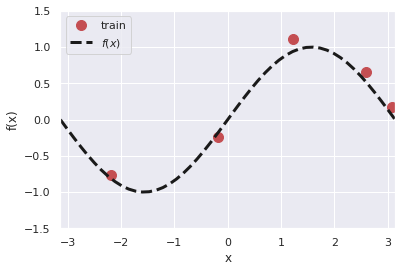

In [8]:
# plot function
def plot_fn(train, test, *fs):
    train_xs, train_ys = train
    
    plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')
    
    if test != None:
        test_xs, test_ys = test
        plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
        plt.plot(test_xs, f(test_xs), '-', linewidth=3)
        
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-1.5, 1.5])
    plt.xlabel("x")
    plt.ylabel("f(x)")

# plot
plt.figure(figsize=(6,4))
plot_fn(train, test)
plt.legend(loc='upper left')
plt.show()

### Neural Networkの定義

Neural Tangentsはjaxのラッパーライブラリなので、NNの定義の仕方もほとんど同じですが、若干の違いがあります。まず、jaxでは次のようにニューラルネットワークを定義します。

In [9]:
from jax.experimental import stax

init_fn, apply_fn = stax.serial(
    stax.Dense(512), stax.Relu,
    stax.Dense(512), stax.Relu,
    stax.Dense(1)
)

一方でNeural Tangentsでは次のように定義をします。

In [10]:
from neural_tangents import stax

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(1)
)

`stax.serial`の戻り値について`init_fn, apply_fn`は同じですが、3番目の`kernel_fn`が増えています。これを用いると、NNGP kernelとNTKに対応する共分散行列を計算できます。また、Denseの最初の引数は出力次元を表します。無限幅と言ってるのに512と指定するのは変な感じですが、この数値が影響を及ぼすのは`init_fn`と`apply_fn`に対してのみであり、`kernel_fn`はユニット数を1にしても同じ挙動をします。

それでは後の回帰に用いるNNを定義しましょう。

In [11]:
import neural_tangents as nt
from neural_tangents import stax

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

ここで、活性化関数には`Erf()` (error function)を用いています。
$$\operatorname {erf}\left(x\right)={\frac  {2}{{\sqrt  {\pi }}}}\int _{0}^{x}e^{{-t^{2}}}\, \text{d}t$$
これはtanh関数に似た形状をしています。使用している理由としては、ガウス分布で積分するときに取り回しがよい、などがあります。

次に有限幅のNNにおいて初期化された重みでの出力を見てみましょう。

In [12]:
prior_draws = []

for _ in range(10):
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, 1))
    prior_draws += [apply_fn(params, test_xs)]

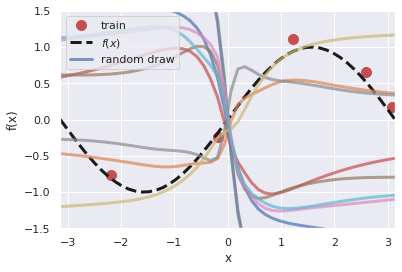

In [13]:
plot_fn(train, test)

for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, alpha=0.7) 
    plt.legend(['train', '$f(x)$', 'random draw'], loc='upper left')
plt.show()

当然、全く回帰していません。次に事前分布に基づくNNGPカーネルで出力の分散を出してみます。

In [14]:
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

`kernel`は共分散行列の初期値で、サイズは`(50, 50)`です (testデータのサンプル数が50であることに注意)。対角成分を取ることで標準偏差`std_dev` (サイズは`(50, )`)を得ます。結果は次のようになります。

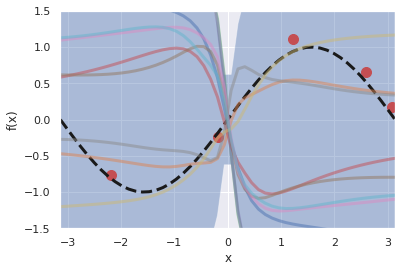

In [15]:
plot_fn(train, test)

plt.fill_between(np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
    plt.plot(test_xs, p, linewidth=3, alpha=0.5)
plt.show()

### NNGPの場合

上で定義した無限幅NNを用いて、ベイズ推論を行います。推論には`neural_tangents.predicted.gp_inference` を用います。この関数に訓練データとテストデータを渡すと、テストデータに対する予測分布の平均と共分散を返します。また、`get`の引数を`nngp`と`ntk`にすることでNNGPとNTKのそれぞれで推論をすることができます。

まずはNNGPを用いて推論をしてみましょう。

In [16]:
nngp_mean, nngp_covariance = nt.predict.gp_inference(
    kernel_fn, train_xs, train_ys, test_xs, 
    diag_reg=1e-4, get='nngp', compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

`nngp_mean`のサイズは`(50, )`, `nngp_covariance`のサイズは`(50, 50)`, `nngp_std`のサイズは`(50, )`となっています。 
平均値 $\pm 2 \text{SD}$の範囲をplotします。

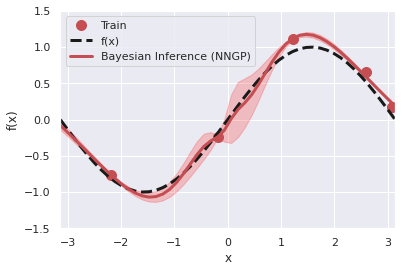

In [17]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

plt.legend(['Train', 'f(x)', 'Bayesian Inference (NNGP)'], loc='upper left')
plt.show()

### NTKの場合

NNGPの場合と同様に推論を実行します。この結果は無限時間最適化したものです (式(8), (9), (10)に基づきます)。

In [18]:
ntk_mean, ntk_covariance = nt.predict.gp_inference(
    kernel_fn, train_xs, train_ys, test_xs, 
    diag_reg=1e-4, get='ntk', compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance)) 

NNGPの場合と同様に、`ntk_mean`のサイズは`(50, )`, `ntk_covariance`のサイズは`(50, 50)`, `ntk_covariance`のサイズは`(50, )`となっています。 

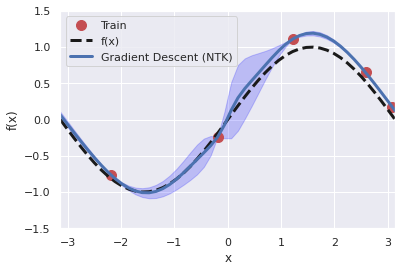

In [19]:
plot_fn(train, test)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.legend(['Train', 'f(x)', 'Gradient Descent (NTK)'], loc='upper left')
plt.show()

### NNGPとNTKの比較
NNGPとNTKの推論の比較をしてみます。殆ど似たような出力であることがわかります。

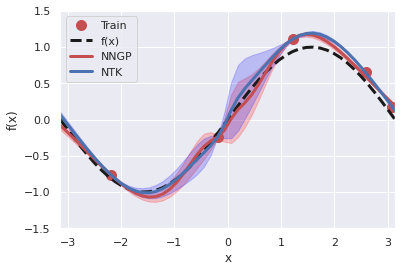

In [20]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    nngp_mean - 2 * nngp_std, 
    nngp_mean +  2 * nngp_std, 
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

plt.legend(['Train', 'f(x)', 'NNGP', 'NTK'], loc='upper left')
plt.show()

### NTKの学習曲線のplot

NTKにおいては無限時間最適化後の収束のみならず、式(6), (7)に基づいて学習曲線も描くことができます。それには`nt.predict.gradient_descent_mse_gp`を用います。

In [21]:
train_predict_fn = nt.predict.gradient_descent_mse_gp(
    kernel_fn, train_xs, train_ys, train_xs, 'ntk', 1e-4, compute_cov=True)
test_predict_fn = nt.predict.gradient_descent_mse_gp(
    kernel_fn, train_xs, train_ys, test_xs, 'ntk', 1e-4, compute_cov=True)

In [22]:
def loss_fn(predict_fn, ys, t):
    mean, cov = predict_fn(t)
    mean = np.reshape(mean, (-1,))
    var = np.diag(cov)
    ys = np.reshape(ys, (-1,))

    mean_predictions = 0.5 * np.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2)

    return mean_predictions

train_loss_fn = functools.partial(loss_fn, train_predict_fn, train_ys)
test_loss_fn = functools.partial(loss_fn, test_predict_fn, test_ys)

In [23]:
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = vmap(train_loss_fn)(ts)
ntk_test_loss_mean = vmap(test_loss_fn)(ts)

学習曲線は次のようになります。

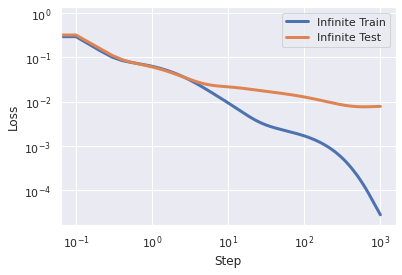

In [24]:
plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['Infinite Train', 'Infinite Test'])
plt.show()

### 有限幅NNとの比較
次に有限幅のNNを複数 (n=100) 訓練し、そのアンサンブルの学習曲線や出力(の平均や分散)をNTKと比較してみましょう。ここで用いる`apply_fn`は上でNNを定義したときのものです (ユニット数の情報はここで使用されます)。

まず、NNを訓練するためのoptimizerを定義します。

In [25]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

次にloss関数とその勾配を定義します。

In [26]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

有限幅NNを訓練します。先にNNの訓練状況を可視化するために`tqdm`をimportします。

In [27]:
from tqdm import tqdm_notebook

訓練のための関数を定義します。

In [28]:
def train_network(key):
    train_losses = []
    test_losses = []

    _, params = init_fn(key, (-1, 1)) 
    opt_state = opt_init(params)
    for i in tqdm_notebook(range(training_steps)):
        train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]  
        test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
        opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)
    
    train_losses = np.concatenate(train_losses)
    test_losses = np.concatenate(test_losses)
    return get_params(opt_state), train_losses, test_losses

学習を実行します。

In [29]:
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key) 

学習が完了したら、NTKの学習曲線と100個のNNの学習曲線の平均を比較してみましょう。

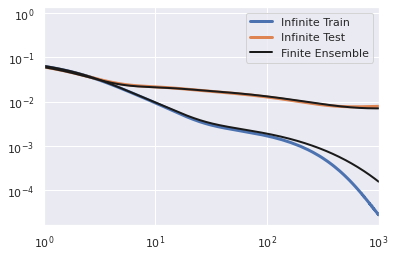

In [30]:
mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')

plt.legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])
plt.show()

青線がNTKのtrain, オレンジ線がNTKのtest, 黒線がNNのアンサンブルですが概ね一致していることがわかります。

最後に出力とその分布を比較してみましょう。

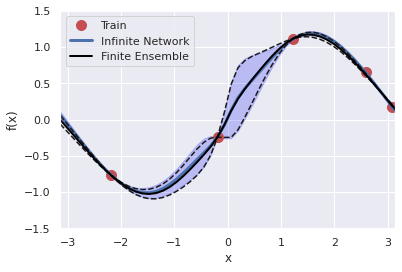

In [31]:
plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)), 
    ntk_mean - 2 * ntk_std, 
    ntk_mean +  2 * ntk_std, 
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

plt.legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])
plt.show()

青がNTKによる予測分布、黒がNNのアンサンブルによる出力の分布です。驚くことに**両者の予測分布がぴったり一致**しています。これを見るまでNeural TangentsはNTKのsimulationが主で数値的にNNを解析するためのライブラリだと思っていました（実際にその方面でNeural Tangentsを使用している論文が多くみられますが）。しかし、同一構造であるとはいえ、複数のNNのアンサンブル (訓練にかなり時間がかかる)と同じ出力を高速に求めることができるというのは機械学習においても有効ではないでしょうか？

同じことは[Google AI blog](https://ai.googleblog.com/2020/03/fast-and-easy-infinitely-wide-networks.html)でも書かれています（以下引用）。
> As such, infinite-width networks can be used as a lens to study deep learning, but also as useful models in their own right.

要はNTKはDeep NNの解析手法として開発されたが、NTK自体が有用なモデルとして活用できるという主張をしています (そして([Arora et al., arXiv. 2019.](https://arxiv.org/abs/1910.01663))が引用されています)。そもそもNNGPとNTKに共通の利点(というよりガウス過程の利点)として予測の不確かさも出力してくれる、というのがあります。機械学習において有用といっても差し支えないとは思います。

ただ、文献を調べると無限幅NNが有限幅NNより優れているかというとそうとも言えないようで。また、NTKとNNGPを機械学習のタスクで比較したときにどちらが優れているかというのも調べ切れていません。詳しい方コメントして頂ければ幸いです（それ以外にもコメントお待ちしています）。

今回の記事では全結合NNにとどまりましたが、Neural TangentsはDeep convolutional GPやConvolutional NTKにも対応しており、例えば無限幅のResNetを構築することができます。画像分類を試しにやろうかと思いましたが、記事が長くなったので次回にしようと思います。

## 参考文献

### NNGP
- Lee et al., [Deep Neural Networks as Gaussian Processes](https://arxiv.org/abs/1711.00165). *ICLR* 2018.
- 持橋 大地, 大羽 成征. 『[ガウス過程と機械学習](http://chasen.org/~daiti-m/gpbook/)』 講談社. 2019.
- 須山 敦志. 『ベイズ深層学習』 講談社. 2019. 
- [深層学習はガウス過程 - 作って遊ぶ機械学習。](http://machine-learning.hatenablog.com/entry/2018/01/13/142612)
- [Deep Neural Networks as Gaussian Processes - HackMD](https://hackmd.io/@FF/BypA3l_BQ?type=view)
- [[DL輪読会]Deep Neural Networks as Gaussian Processes](https://www.slideshare.net/DeepLearningJP2016/dldeep-neural-networks-as-gaussian-processes) 

### NTK
- Jacot et al. [Neural Tangent Kernel: Convergence and Generalization in Neural Networks](https://arxiv.org/abs/1806.07572). *NIPS*. 2018.
- Lee et al. [Wide Neural Networks of Any Depth Evolve as Linear Models Under Gradient Descent](https://arxiv.org/abs/1902.06720). *NeurIPS.* 2019.
- 甘利 俊一. 『新版 情報幾何学の新展開』. サイエンス社. 2019.
- [Understanding the Neural Tangent Kernel – Rajat's Blog](https://rajatvd.github.io/NTK/)
- [kwignb/Neural-Tangent-Kernel](https://github.com/kwignb/Neural-Tangent-Kernel)
- [Deriving the Neural Tangent Kernel | Bryn Elesedy](https://brynhayder.github.io/jekyll/update/2019/04/02/neural-tangent-kernel.html)
- [深層学習に関わる驚異の発見：Neural Tangent Kernel - Qiita](https://qiita.com/xkotaro/items/720616858973a3bda99e)
- [Neural Tangent Kernel - ややプログラム紀行](https://dora119.hateblo.jp/entry/2019/11/06/035555)
- [深層学習の数理](https://www.slideshare.net/trinmu/ss-161240890)